In [1]:
!nvcc --version
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu124
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
!pip install torchmetrics

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.4/883.4 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
  

Using device: cuda
Loading dataset...
Handling missing values...
Data cleaning done.
Number of Classes: 2
Class Distribution:
 Label
1    148115
0     58521
Name: count, dtype: int64
Initializing dataset...
Building vocabulary...
Vocabulary size: 897305
Creating graphs with duplicate node handling...
Total graphs created: 206636
Dataset initialization complete.


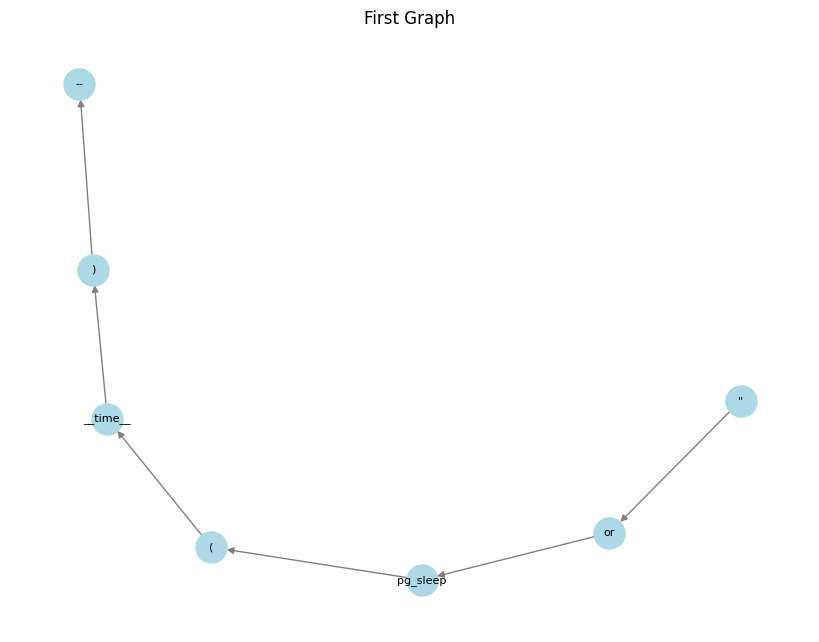

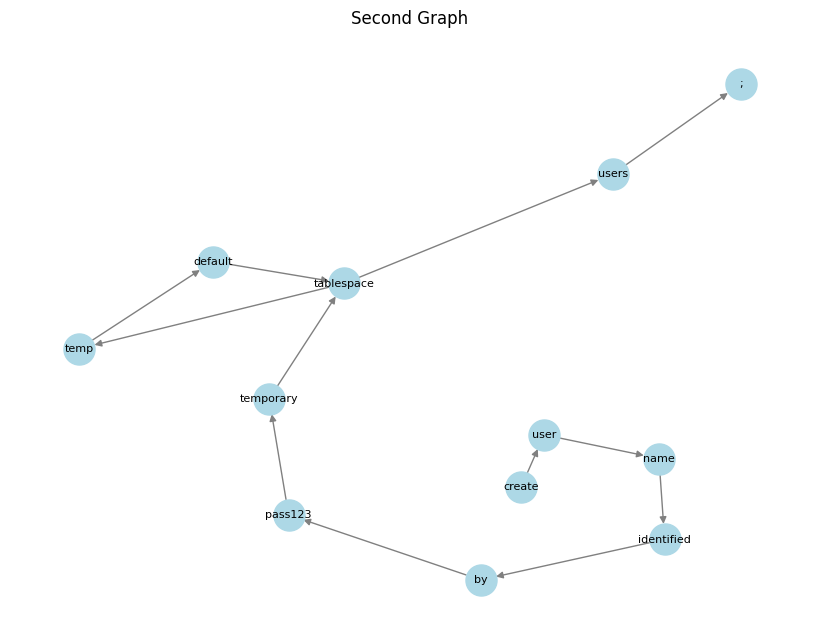

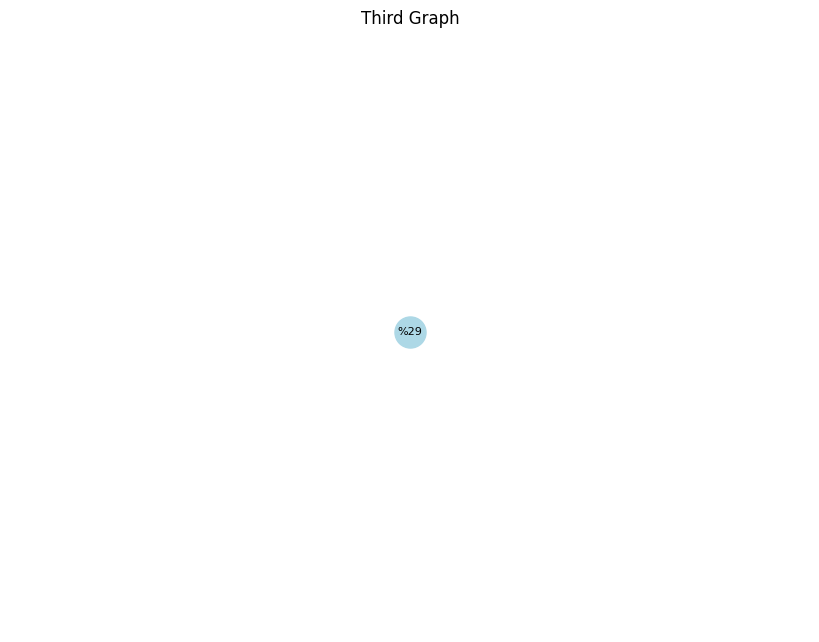

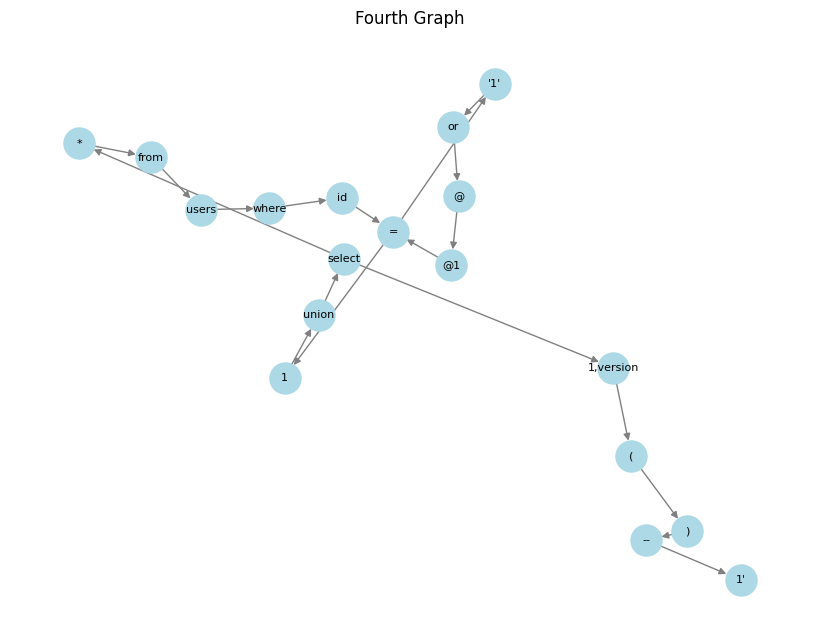

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from tqdm import tqdm
import networkx as nx

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/content/dataset.csv", on_bad_lines='skip', engine='python')



# Handle missing values
print("Handling missing values...")
df["Payload"] = df["Payload"].fillna("").astype(str)
df["Label"] = pd.to_numeric(df["Label"], errors="coerce").fillna(0).astype(int)
print("Data cleaning done.")

# Check dataset info
num_classes = df["Label"].nunique()
class_distribution = df["Label"].value_counts()

print(f"Number of Classes: {num_classes}")
print("Class Distribution:\n", class_distribution)

# Graph dataset class
class InjectionDataset:
    def __init__(self, df):
        print("Initializing dataset...")
        self.df = df
        self.vocab = {}
        self._build_vocab()
        self.graphs, self.labels = self._create_graphs()
        print("Dataset initialization complete.")

    def _build_vocab(self):
        print("Building vocabulary...")
        vocab = {}
        for payload in self.df["Payload"]:
            tokens = self._tokenize(payload)
            for token in tokens:
                if token not in vocab:
                    vocab[token] = len(vocab)
        self.vocab = vocab
        print(f"Vocabulary size: {len(self.vocab)}")

    def _tokenize(self, text):
        return text.lower().replace(";", " ; ").replace("(", " ( ").replace(")", " ) ").split()

    def _create_graphs(self):
        print("Creating graphs with duplicate node handling...")
        graphs = []
        labels = []

        for payload, label in zip(self.df["Payload"], self.df["Label"]):
            tokens = self._tokenize(payload)
            unique_tokens = list(set(tokens))  # Unique tokens as nodes
            num_nodes = len(unique_tokens)

            g = dgl.graph(([], []))
            g.add_nodes(num_nodes)

            token_ids = [self.vocab[t] for t in unique_tokens]
            g.ndata["feat"] = torch.tensor(token_ids, dtype=torch.long).unsqueeze(1)

            # Create edges between occurrences of the same word
            token_map = {token: idx for idx, token in enumerate(unique_tokens)}
            src, dst = [], []

            for i in range(len(tokens) - 1):
                src.append(token_map[tokens[i]])
                dst.append(token_map[tokens[i + 1]])

            g.add_edges(src, dst)

            graphs.append(g)
            labels.append(label)

        print(f"Total graphs created: {len(graphs)}")
        return graphs, torch.tensor(labels, dtype=torch.long, device=device)






# Create dataset
dataset = InjectionDataset(df)
graphs = dataset.graphs
labels = dataset.labels

# Function to visualize a DGL graph with node labels
import networkx as nx

# Function to visualize a DGL graph with node labels
def plot_graph(g, vocab, title="Graph Visualization"):
    g = g.cpu()  # Move graph to CPU
    nx_g = g.to_networkx()

    pos = nx.spring_layout(nx_g)  # Positioning using spring layout

    # Get node labels from vocabulary
    node_labels = {i: list(vocab.keys())[list(vocab.values()).index(g.ndata["feat"][i].item())] for i in range(g.num_nodes())}

    plt.figure(figsize=(8, 6))
    nx.draw(nx_g, pos, with_labels=True, labels=node_labels, node_size=500, node_color="lightblue", edge_color="gray", font_size=8)
    plt.title(title)
    plt.show()

# Plot the first two graphs
plot_graph(graphs[0], dataset.vocab, title="First Graph")
plot_graph(graphs[1], dataset.vocab, title="Second Graph")
plot_graph(graphs[2], dataset.vocab, title="Third Graph")
plot_graph(graphs[4], dataset.vocab, title="Fourth Graph")

import json

# Save vocabulary
with open("vocab.json", "w") as f:
    json.dump(dataset.vocab, f)



In [5]:
# Split dataset (fixed stratification)
print("Splitting dataset...")
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels.cpu(), test_size=0.2, random_state=42, stratify=labels.cpu()
)

print(f"Training samples: {len(train_graphs)}, Test samples: {len(test_graphs)}")

# Create data loaders
batch_size = 32
print("Creating data loaders...")
train_loader = GraphDataLoader(
    list(zip(train_graphs, train_labels)), batch_size=batch_size, shuffle=True
)
test_loader = GraphDataLoader(
    list(zip(test_graphs, test_labels)), batch_size=batch_size
)
print("Data loaders ready.")

# GCN Model with improvements
class GCNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, dropout=0.6):
        super().__init__()
        print("Initializing Improved GCN model...")

        self.embed = nn.Embedding(vocab_size, embed_dim)

        # Three GraphConv layers for better feature extraction
        self.conv1 = GraphConv(embed_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv3 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)

        # Batch Normalization to stabilize training
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        print("Model initialized.")

    def forward(self, g):
        h = self.embed(g.ndata["feat"].squeeze(1).to(self.embed.weight.device))
        h = F.relu(self.bn1(self.conv1(g, h)))
        h = F.relu(self.bn2(self.conv2(g, h)))
        h = F.relu(self.bn3(self.conv3(g, h)))

        with g.local_scope():
            g.ndata["h"] = h
            hg = dgl.mean_nodes(g, "h")

        hg = self.dropout(F.relu(self.fc1(hg)))
        return self.fc2(hg)

# Training setup
print("Setting up training...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCNClassifier(len(dataset.vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss()
print("Training setup complete.")

Splitting dataset...
Training samples: 165308, Test samples: 41328
Creating data loaders...
Data loaders ready.
Setting up training...
Initializing Improved GCN model...
Model initialized.
Training setup complete.


Using device: cuda
Starting training...
Epoch 1/10 started...


Epoch 1/10: 100%|██████████| 5166/5166 [04:48<00:00, 17.91it/s, loss=0.208]


Epoch 1 | Loss: 0.2082 | Train Acc: 94.87% | Val Acc: 94.84%
New best model saved with Val Acc: 94.84%
Epoch 2/10 started...


Epoch 2/10: 100%|██████████| 5166/5166 [04:42<00:00, 18.29it/s, loss=0.141]


Epoch 2 | Loss: 0.1410 | Train Acc: 96.01% | Val Acc: 95.87%
New best model saved with Val Acc: 95.87%
Epoch 3/10 started...


Epoch 3/10: 100%|██████████| 5166/5166 [04:42<00:00, 18.28it/s, loss=0.12]


Epoch 3 | Loss: 0.1204 | Train Acc: 96.50% | Val Acc: 96.21%
New best model saved with Val Acc: 96.21%
Epoch 4/10 started...


Epoch 4/10: 100%|██████████| 5166/5166 [04:41<00:00, 18.34it/s, loss=0.107]


Epoch 4 | Loss: 0.1071 | Train Acc: 96.74% | Val Acc: 96.23%
New best model saved with Val Acc: 96.23%
Epoch 5/10 started...


Epoch 5/10: 100%|██████████| 5166/5166 [04:41<00:00, 18.38it/s, loss=0.099]


Epoch 5 | Loss: 0.0990 | Train Acc: 96.99% | Val Acc: 96.37%
New best model saved with Val Acc: 96.37%
Epoch 6/10 started...


Epoch 6/10: 100%|██████████| 5166/5166 [04:40<00:00, 18.41it/s, loss=0.0922]


Epoch 6 | Loss: 0.0922 | Train Acc: 97.11% | Val Acc: 96.44%
New best model saved with Val Acc: 96.44%
Epoch 7/10 started...


Epoch 7/10: 100%|██████████| 5166/5166 [04:40<00:00, 18.43it/s, loss=0.0856]


Epoch 7 | Loss: 0.0856 | Train Acc: 97.16% | Val Acc: 96.31%
Epoch 8/10 started...


Epoch 8/10: 100%|██████████| 5166/5166 [04:40<00:00, 18.44it/s, loss=0.0815]


Epoch 8 | Loss: 0.0815 | Train Acc: 97.45% | Val Acc: 96.33%
Epoch 9/10 started...


Epoch 9/10: 100%|██████████| 5166/5166 [04:39<00:00, 18.49it/s, loss=0.0773]


Epoch 9 | Loss: 0.0773 | Train Acc: 97.50% | Val Acc: 96.31%
Epoch 10/10 started...


Epoch 10/10: 100%|██████████| 5166/5166 [04:40<00:00, 18.45it/s, loss=0.0748]


Epoch 10 | Loss: 0.0748 | Train Acc: 97.58% | Val Acc: 96.01%
Training complete. Best model saved as /content/gcn_model.pth with accuracy 96.44%
Evaluating model on test set...


Final Test Accuracy: 96.01%


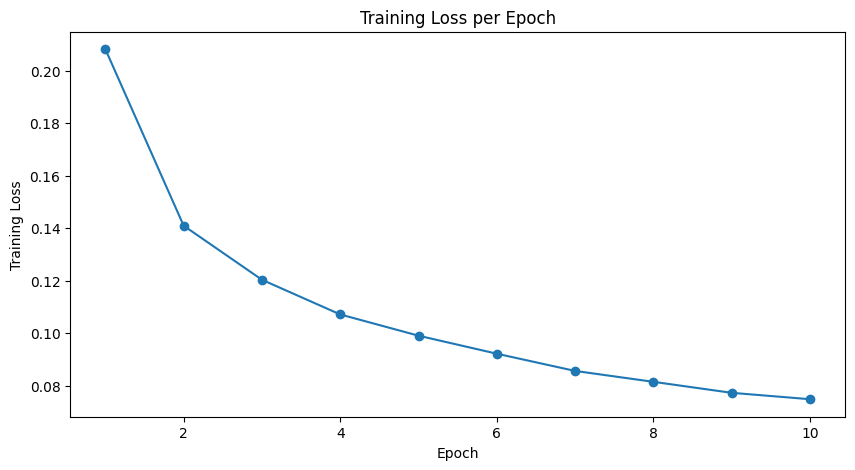

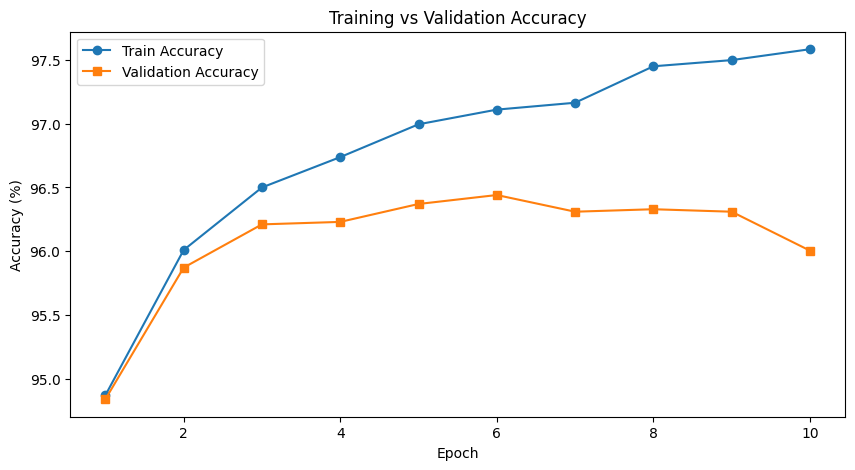

In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from tqdm import tqdm
import networkx as nx
from torchmetrics.classification import Accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Accuracy Metric
accuracy_metric = Accuracy(task="multiclass", num_classes=2).to(device)

# Function to compute accuracy with tqdm progress bar
def compute_accuracy(model, loader):
    model.eval()
    accuracy_metric.reset()

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for batched_graphs, batched_labels in progress_bar:
            batched_graphs = batched_graphs.to(device)
            batched_labels = batched_labels.to(device).long()

            logits = model(batched_graphs)
            predicted = torch.argmax(logits, dim=1)

            accuracy_metric.update(predicted, batched_labels)

    return accuracy_metric.compute().item() * 100  # Convert to percentage


# Training loop with tqdm
num_epochs = 10
train_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0
best_model_path = "/content/gcn_model.pth"

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} started...")
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for batched_graphs, batched_labels in progress_bar:
        batched_graphs = batched_graphs.to(device)
        batched_labels = batched_labels.to(device).long()

        logits = model(batched_graphs)
        loss = criterion(logits, batched_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    train_loss = total_loss / len(train_loader)
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Val Acc: {best_val_acc:.2f}%")

print(f"Training complete. Best model saved as {best_model_path} with accuracy {best_val_acc:.2f}%")

# Final evaluation
print("Evaluating model on test set...")
test_accuracy = compute_accuracy(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Plot training loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.show()

# Plot accuracy trends
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()
